# Detecting Pneumonia in Chest X-Rays with Deep Learning

Flatiron School Phase 4 Data Science Project Author: Robert Harrow

## Overview

Chest x-ray screening is a reliable method to diagnose pneumonia. However, it requires a radiologist to identify the signs of pneumonia in the images. ACME Radiology would like to leverage computer vision to assist in diagnosing x-ray images. They hire us to develop a model that can achieve this task while attaining some minimum success thresholds.

In this project, we'll iteratively explore different deep learning models using the **Keras** library. We choose this package because it gives us easy access to tools for constructing artificial neural networks that can be used for image classification problems - such as classifying whether an image of a chest x-ray has signs of pneumonia. The project will start with simple Densely connected neural networks, then move on to working with Convolutional Neural Networks (CNNs). CNNs are well equipped for image classification so we expect to achieve best results with these neural nets.

We'll start by designing and implementing our own simple neural networks and train them on our data. **Keras** also allows us to bring in other pre-trained models and leverage **transfer learning** to solve our business problem.

To achieve this, we'll be training and testing our model on over 5,000 images obtained from Kermany et al. We'll train our models on the raw image data as well as pre-processed images through Contrast Limited Adaptive Histogram Equalization (CLAHE). The latter is a technique for increasing image contrast, which we hope will lead to better model performance.


#### Objectives
1. Implement a neural network for classifying X-Ray images to detect pneumoniua
2. Iterate through models to achieve at least a 0.90 F1 score

### Evaluation Metrics

We want our models to achieve, at a minimum: **90% F1 score**.

**Why F1?** It's important for our model to not misclassify positive pneumonia cases, so we have some tolerance for false positives. If this was our only goal, **Recall** would be a better metric. However, ACME Radiology also wants this model to act as a resource and time saver. Too many false positives would defeat the purpose of using a model, so we need to also have a model with good **Precision**. **F1** is a harmonic mean of **precision** and **recall**, which makes it the best-suited metric for our business case.

#### F1 Formula
$$ F1 = {2 * Precision x Recall \over Precision + Recall} $$

#### Precision Formula
$$ Precision = {True Positives \over Predicted Positives} $$

#### Recall Formula
$$ Recall = {True Positivies \over Actual Total Positives} $$

#### Importing Libraries

In [1]:
# Tensorflow Keras allow us to construct models and prep data
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50

# Our data has a slight imbalance so we'll use class_weights to deal with it
from sklearn.utils import class_weight

# Libraries for evaluating models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# We'll use callbacks to save our models, adjust learning rate and log fitting history
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [2]:
# Standard libraries for navigating files, wrangling data and creating visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import glob, os, cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

## Data

The data used in this project comes from Kermany et al. on [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3).

This dataset contains thousands of validated OCT and Chest X-Ray images. For this project, we will only be working with the Chest X-Ray images which are contained in the 'chest_xray' folder. To recreate this repo, download and extract the data, and place the 'chest_xray' folder in the root directory.

The images are already distributed into a 'train' and 'test' folder. Furthermore, each of those folders is subdivided into a 'PNEUMONIA' or 'NORMAL' subfolder which correspond to the two classes we want our model to identify.

#### Directory Structure

<img align="left" src="images/file-directory.png">

In [3]:
# The downloaded files come with some unwanted files so we can quickly run a script to delete those
!find . -name ".DS_Store" -delete

#### Class Distribution
Let's first check the class distribution.

In [4]:
# Counting the number of image files in our train folders
trainPneumoniaCounter = len(glob.glob1('chest_xray/train/PNEUMONIA', '*.jpeg'))
trainNORMALCounter = len(glob.glob1('chest_xray/train/NORMAL', '*.jpeg'))

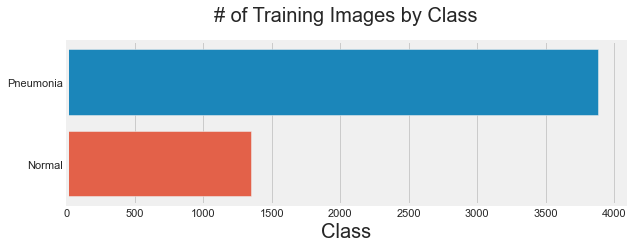

We have a total of 5232 chest x-rays.


In [5]:
# Now let's plot those
plt.figure(figsize=(10,3))
plt.style.use('fivethirtyeight')
sns.barplot(x=[trainPneumoniaCounter,trainNORMALCounter],
            y=['Pneumonia', 'Normal'],
           orient ='h')
plt.title('# of Training Images by Class', fontsize = 20, pad=20)
plt.xlabel('Class', fontsize = 20)
plt.show()

print("We have a total of {} chest x-rays.".format(trainPneumoniaCounter+trainNORMALCounter))

There is a mild class imbalance in our training data. We'll account for this when building our models using class_weights in the pre-processing step.

#### Previewing Images
Next, it would be good to see how the normal and pneumonia images look like in case there is anything interesting to learn from inspecting them.

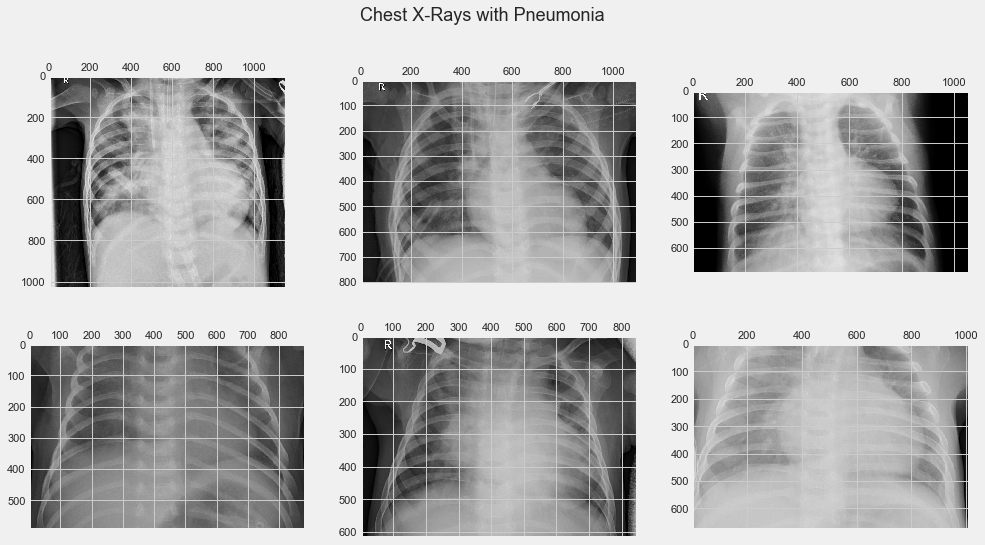

In [6]:
# Visualize x-rays with pneumonia 
pneumonia_samples = ['ps_1', 'ps_2', 'ps_3', 'ps_4', 'ps_5', 'ps_6']

for i, image in enumerate(os.listdir("chest_xray/train/PNEUMONIA/")[:6]):
    pneumonia_samples[i] = cv2.imread("chest_xray/train/PNEUMONIA/" + image)
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Chest X-Rays with Pneumonia", fontsize=18, y=1)

for i in range(6):
    ncols = 3
    nrows = 2
    ax = plt.subplot(nrows, ncols, i + 1)
    img = pneumonia_samples[i]
    ax.matshow(img)

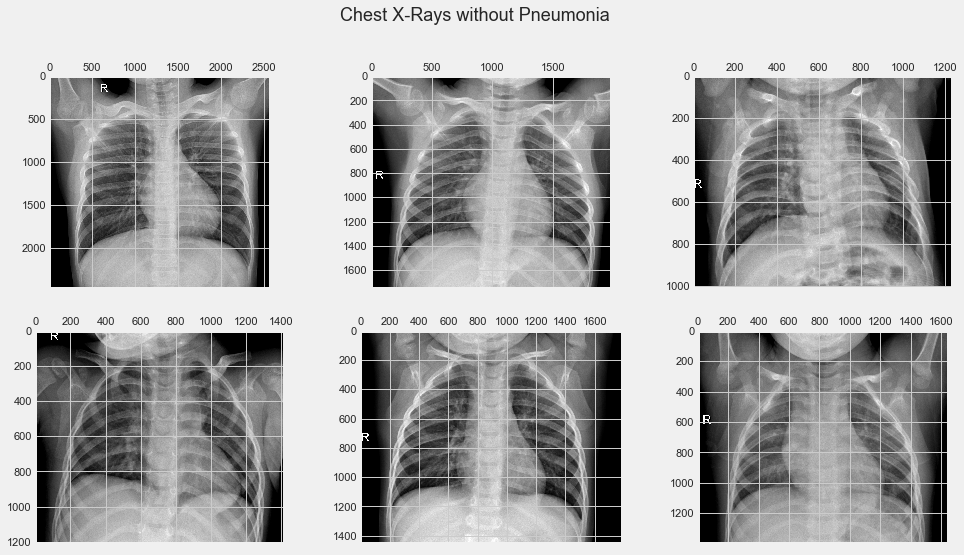

In [7]:
# Visualize x-rays without pneumonia
normal_samples = ['ns_1', 'ns_2', 'ns_3', 'ns_4', 'ns_5', 'ns_6']

for i, image in enumerate(os.listdir("chest_xray/train/NORMAL/")[:6]):
    normal_samples[i] = cv2.imread("chest_xray/train/NORMAL/" + image)
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.2)
plt.suptitle("Chest X-Rays without Pneumonia", fontsize=18, y=1)

for i in range(6):
    ncols = 3
    nrows = 2
    ax = plt.subplot(nrows, ncols, i + 1)
    img = normal_samples[i]
    ax.matshow(img)

To an untrained eye, these images look similar. One interesting note: it looks like these images are pretty standardized. This isn't surprising since chest x-rays have a format for how they are conducted. That means we probably don't have to worry about creating variations of our images (flipped, rotated, etc.) since they are, for the most part, pretty standard. 

## Data Preprocessing

### Splittig & Normalizing

The downloaded data is already split up into train and test folders. However, we would also like to split out about 10% of our train data to be used as a validation set. That way, we can measure our model iterations without touching the test data.

We will also use this opportunity to rescale the image data so it falls between 0 and 1 by dividing pixel intensity by 255.

We do not transform the images beyond that because by visually inspecting the images above, it seems they are all pretty standard. Should we run into issues with our model, we may revisit that in a future step.

In [8]:
# Configs for image Generator
target_size = (224, 224)
train_batch = 4710
test_batch = 522
val_batch = 624
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'

train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 4710,
                                                     subset='training',
                                                     seed=123)

val_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 522,
                                                     subset='validation',
                                                     seed=123)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     test_path,
                                                     target_size=target_size,
                                                     batch_size=624,
                                                     seed=123)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
# Check the classes
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [11]:
# Reshaping the images to be used with our densley connected models
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [12]:
# Reshaping the labels
train_y = np.reshape(train_labels[:,0], (4710,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (522,1))

### Setting Class Weights

From our earlier data exploration, we noticed there is a class imbalance present in our dataset. To deal with that, we will use Sklearn's compute_class_weight function to calculate the appropriate weights to balance our classes.

In [13]:
class_weights = class_weight.compute_class_weight(
               class_weight = 'balanced',
               classes = np.unique(train_generator.classes), 
               y = train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9382716049382716, 1: 0.6738197424892703}

### Creating Helper Functions to Evaluate Models
As we iterate through different models, we will be constantly wanting to check how they are performing and look for things like overfitting and how the models are doing based on our evaluation metrics.
To do this, we create 2 helper functions.

The first will create a confusion metric and calculate Accuracy, Precision, Recall and F1 for our model.

The second function will use the history to show how our accuracy and loss is doing by epoch. We ideally want to see both train and validation loss/accuracy converge as epochs grow. If they don't stabilize and converge, it may indicate overfitting.

In [14]:
# Function for calculating evaluation metrics & showing conusion matrix

def evaluate_results(model, x, y):
          
    if y.shape[1] == 1:
        y_hat_test = model.predict(x)
        thresh = 0.5
        y_pred = (y_hat_test > thresh).astype(np.int)
        y_true = y.astype(np.int)
    else:
        y_pred  = []
        y_true = []
        for element in model.predict(x):
            highest_odds = np.max(element)
            ind_get = np.where(element[0] == highest_odds)
            ind = ind_get[0]
            if ind == 0:
                y_pred.append(0)
            else:
                y_pred.append(1)
        for element in y:
            highest_odds = np.max(element)
            ind_get = np.where(element[0] == highest_odds)
            ind = ind_get[0]
            if ind == 0:
                y_true.append(0)
            else:
                y_true.append(1) 
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred)
    print('F1 score: %f' % f1)

In [15]:
# Function for plotting Loss & Accuracy
def visualize_training_results(log_file_path):
    his_log = pd.read_csv(log_file_path)
    ax = his_log.plot(x="epoch", y="acc", legend=False)
    ax2 = ax.twinx()
    his_log.plot(x="epoch", y="val_acc", ax=ax2, legend=False, color="r")
    ax.figure.legend()
    plt.title("Accuracy")
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    plt.show()

    ax = his_log.plot(x="epoch", y="loss", legend=False)
    ax2 = ax.twinx()
    his_log.plot(x="epoch", y="val_loss", ax=ax2, legend=False, color="r")
    ax.figure.legend()
    plt.title("Loss")
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    plt.show()

## Modeling
### Baseline Model

We start by building a simple densely connected model with 3 activation layers. This will serve as a baseline for judging the performance of other models in the project.

In [16]:
# Build a baseline fully connected model
baseline_model = Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(150528,))) # 2 hidden layers
baseline_model.add(layers.Dense(7, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                3010580   
                                                                 
 dense_1 (Dense)             (None, 7)                 147       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 3,010,735
Trainable params: 3,010,735
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the image
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

baseline_logger = CSVLogger('logs/baseline.log')

baseline_history = baseline_model.fit(train_img,
                    train_y,
                    class_weight=class_weights,
                    epochs=20,
                    batch_size=32,
                    callbacks=[baseline_logger],
                    validation_data=(val_img, val_y))

Epoch 1/20
148/148 [==============================] - 2s 10ms/step - loss: 0.8688 - acc: 0.7314 - val_loss: 0.6877 - val_acc: 0.7433
Epoch 2/20
148/148 [==============================] - 1s 9ms/step - loss: 0.3473 - acc: 0.7420 - val_loss: 0.2727 - val_acc: 0.7433
Epoch 3/20
148/148 [==============================] - 1s 10ms/step - loss: 0.2899 - acc: 0.8102 - val_loss: 0.3101 - val_acc: 0.8755
Epoch 4/20
148/148 [==============================] - 1s 9ms/step - loss: 0.2538 - acc: 0.9036 - val_loss: 0.2475 - val_acc: 0.9234
Epoch 5/20
148/148 [==============================] - 1s 9ms/step - loss: 0.2503 - acc: 0.9051 - val_loss: 0.3582 - val_acc: 0.8582
Epoch 6/20
148/148 [==============================] - 1s 9ms/step - loss: 0.2305 - acc: 0.9189 - val_loss: 0.2101 - val_acc: 0.9579
Epoch 7/20
148/148 [==============================] - 1s 9ms/step - loss: 0.2144 - acc: 0.9270 - val_loss: 0.2365 - val_acc: 0.9157
Epoch 8/20
148/148 [==============================] - 1s 9ms/step - loss: 

17/17 [==============================] - 0s 3ms/step


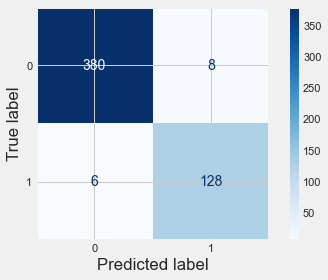

Accuracy: 0.973180
Precision: 0.941176
Recall: 0.955224
F1 score: 0.948148


In [19]:
evaluate_results(baseline_model, val_img, val_y)

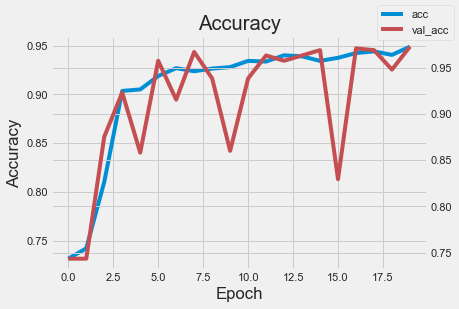

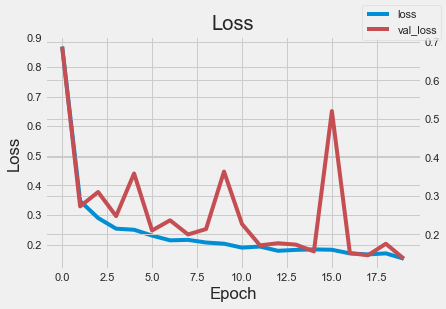

In [20]:
visualize_training_results('logs/baseline.log')

Even the first baseline model is doing pretty good in terms of F1 and precision.

However, the validation loss/accuracy isn't stable and didn't quite converge with training. We can address this by running a model with more epochs and more complexity.

### Iteration 1 - Increasing Model Complexity

Our next attempt is a more complex Densely Conencted model with 5 layers. We will also run this through more epochs.

In [21]:
iter_1_model = Sequential()
iter_1_model.add(layers.Dense(20, activation='relu', input_shape=(150528,)))
iter_1_model.add(layers.Dense(15, activation='relu'))
iter_1_model.add(layers.Dense(10, activation='relu'))
iter_1_model.add(layers.Dense(5, activation='relu'))
iter_1_model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
iter_1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                3010580   
                                                                 
 dense_4 (Dense)             (None, 15)                315       
                                                                 
 dense_5 (Dense)             (None, 10)                160       
                                                                 
 dense_6 (Dense)             (None, 5)                 55        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,011,116
Trainable params: 3,011,116
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile the image
iter_1_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

# Define callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

iter_1_logger = CSVLogger('logs/iter_1.log')

iter_1_hist = iter_1_model.fit(train_img,
                    train_y,
                    class_weight=class_weights,
                    epochs=60,
                    batch_size=32,
                    callbacks=[reduce_lr, iter_1_logger],
                    validation_data=(val_img, val_y))

Epoch 1/60
148/148 [==============================] - 2s 10ms/step - loss: 0.5094 - acc: 0.7338 - val_loss: 0.5939 - val_acc: 0.7433 - lr: 0.0100
Epoch 2/60
148/148 [==============================] - 1s 9ms/step - loss: 0.3755 - acc: 0.7420 - val_loss: 0.3869 - val_acc: 0.7433 - lr: 0.0100
Epoch 3/60
148/148 [==============================] - 1s 9ms/step - loss: 0.3134 - acc: 0.8344 - val_loss: 0.5611 - val_acc: 0.7893 - lr: 0.0100
Epoch 4/60
148/148 [==============================] - 1s 9ms/step - loss: 0.2719 - acc: 0.8832 - val_loss: 0.3426 - val_acc: 0.8563 - lr: 0.0100
Epoch 5/60
148/148 [==============================] - 1s 10ms/step - loss: 0.2517 - acc: 0.8951 - val_loss: 0.3681 - val_acc: 0.8678 - lr: 0.0100
Epoch 6/60
148/148 [==============================] - 1s 9ms/step - loss: 0.2380 - acc: 0.9093 - val_loss: 0.2190 - val_acc: 0.9579 - lr: 0.0100
Epoch 7/60
148/148 [==============================] - 1s 9ms/step - loss: 0.2179 - acc: 0.9217 - val_loss: 0.2030 - val_acc: 0.9

Epoch 57/60
148/148 [==============================] - 1s 9ms/step - loss: 0.0923 - acc: 0.9699 - val_loss: 0.0874 - val_acc: 0.9770 - lr: 8.0000e-05
Epoch 58/60
148/148 [==============================] - 1s 9ms/step - loss: 0.0922 - acc: 0.9701 - val_loss: 0.0874 - val_acc: 0.9770 - lr: 1.6000e-05
Epoch 59/60
148/148 [==============================] - 1s 9ms/step - loss: 0.0922 - acc: 0.9701 - val_loss: 0.0874 - val_acc: 0.9770 - lr: 1.6000e-05
Epoch 60/60
148/148 [==============================] - 1s 9ms/step - loss: 0.0922 - acc: 0.9705 - val_loss: 0.0874 - val_acc: 0.9770 - lr: 1.6000e-05


17/17 [==============================] - 0s 3ms/step


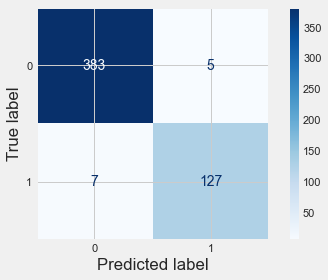

Accuracy: 0.977011
Precision: 0.962121
Recall: 0.947761
F1 score: 0.954887


In [24]:
evaluate_results(iter_1_model, val_img, val_y)

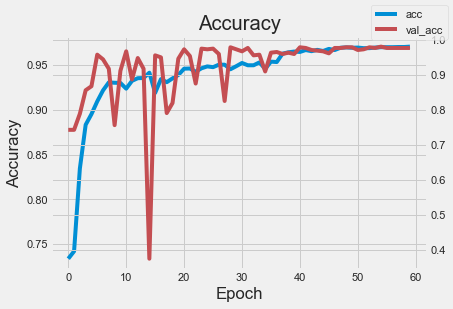

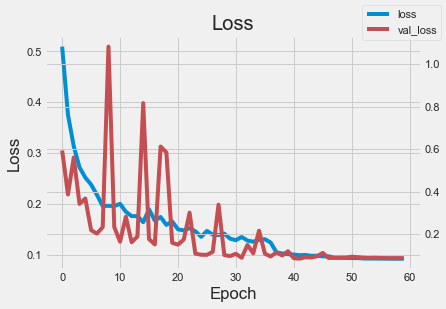

In [25]:
visualize_training_results('logs/iter_1.log')

Wow! Much better! This model has a .95 F1 score and is already above the threshold we set out initially. The training and validation sets are also converging nicely.

Given we achieved this so early, we will aim higher. We haven't even tested models yet that are better suited for the problem at hand (CNNs), and given we have the time, we'll continue testing different models to see if we can get an F1 score above 0.95.

This is better, but now this model is starting to miss penumonia cases. It mislabeled 15 cases.

### Convolutional Neural Networks (CNNs)
Convolutional Neural Networks (CNNs) are an algorithm well-suited for image processing tasks. They pass filters over an image and assign importance to different feature images for classification. This can make them well-suited for the task at hand, as we're trying to detect Pneumonia.

**IMPORTANT:** Beginning with this step, we will start saving the models locally. This is done to save time since fitting these models can take over an hour. If you wish to fit these models locally, uncoment the code below and simply comment out the code that loads the saved model.

In [26]:
# Path where we will save the first CNN model
first_cnn_checkpoint_filepath = 'models/first_cnn_model.h5'

##### Run the cell below to load the pre-trained model

In [27]:
first_cnn_model = load_model(first_cnn_checkpoint_filepath)

#### Uncomment & run the cell below if you want to compile & fit the model on your local machine

In [28]:
# # Constructing the model architecture

# first_cnn_model = models.Sequential()

# first_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(224, 224, 3)))
# first_cnn_model.add(layers.MaxPooling2D((2, 2)))

# first_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
# first_cnn_model.add(layers.MaxPooling2D((2, 2)))

# first_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# first_cnn_model.add(layers.MaxPooling2D((2, 2)))

# first_cnn_model.add(layers.Flatten())
# first_cnn_model.add(layers.Dense(64, activation='relu'))
# first_cnn_model.add(layers.Dense(1, activation='sigmoid'))

# # Compiling the model
# first_cnn_model.compile(loss='binary_crossentropy',
#               optimizer="sgd",
#               metrics=['acc'])

# # Define callbacks that monitor the accuracy and save the best model

# first_cnn_checkpoint_callback = ModelCheckpoint(
#     filepath=first_cnn_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# first_cnn_logger = CSVLogger('logs/first_cnn_log.log')

# # Fit the model & save its history

# first_cnn_hist = first_cnn_model.fit(train_images,
#                     train_y,
#                     class_weight=class_weights,
#                     epochs=50,
#                     batch_size=32,
#                     callbacks=[first_cnn_checkpoint_callback, reduce_lr, first_cnn_logger],
#                     validation_data=(val_images, val_y))

In [29]:
first_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

17/17 [==============================] - 1s 82ms/step


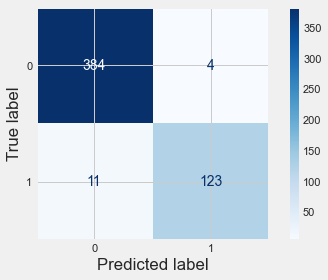

Accuracy: 0.971264
Precision: 0.968504
Recall: 0.917910
F1 score: 0.942529


In [30]:
# Evaluation metrics
evaluate_results(first_cnn_model, val_images, val_y)

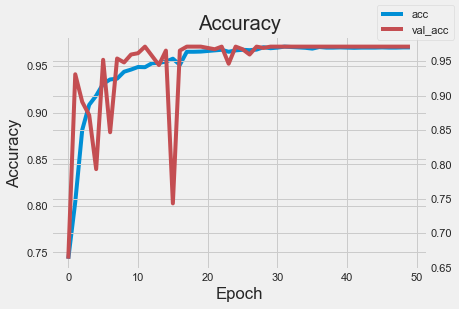

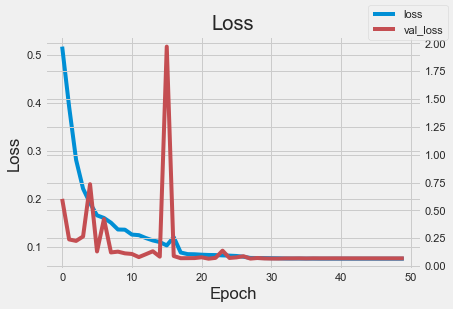

In [31]:
visualize_training_results('logs/first_cnn_log.log')

Our first CNN model is doing better than the baseline, but it's still missing some positive cases of Pneumonia (predicted 'NORMAL' 12 times when it in fact was a case of Pneumonia). The second Densley conencted model did better in terms of F1.

We'll try to further improve the model's ability to pick up on Pneumonia by making it more obvious in our images.

### Contrast Limited Adaptive Histogram Equalization (CLAHE)
Histogram Equalization is a type of image processing that increases the global contrast in images. It allows areas of lower contrast to gain a higher contrast. When we visually inspected the images of pneumonia above we saw that while the bones were pretty clear in the images, the virus/bacteria could be a bit more dull (in other words it has a lower range of intensity values).

[Research](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949) published in 2022 showed that using Histogram Equalization led to improved performance of CNNs in image classification tasks for Pneumonia and COVID-19. We will try to implementat those here.

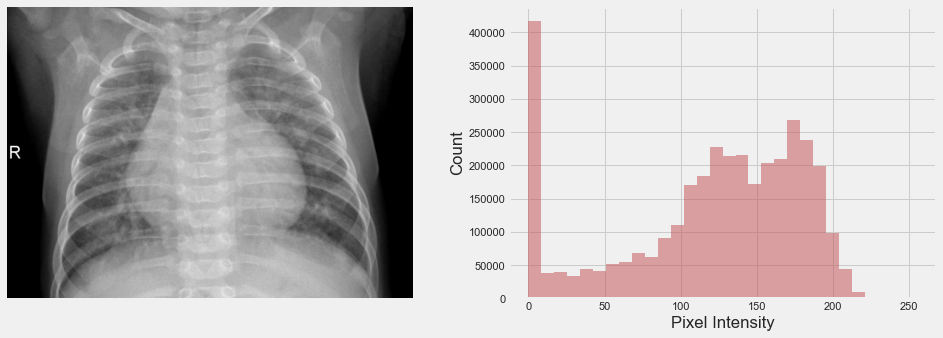

In [32]:
# Select random image
img = cv2.imread('chest_xray/train/PNEUMONIA/BACTERIA-30629-0001.jpeg')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
his = plt.subplot(1,2,2)
his.set_ylabel('Count')
his.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(img[:,:,:].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);

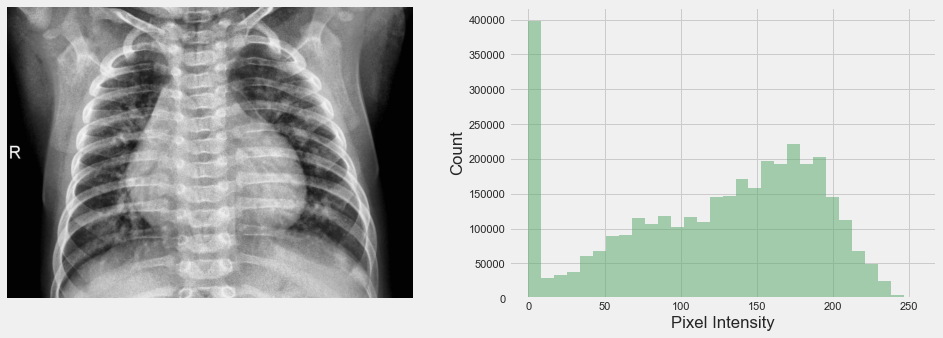

In [33]:
img_prepped = cv2.imread('chest_xray/train/PNEUMONIA/BACTERIA-30629-0001.jpeg', 0)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
img_transformed = clahe.apply(img_prepped)
cv2.imwrite('images/transformed.jpg', img_transformed)
img_transformed = cv2.imread('images/transformed.jpg')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(img_transformed)
plt.axis('off')
his = plt.subplot(1,2,2)
his.set_ylabel('Count')
his.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(img_transformed[:,:,:].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);

To better illustrate what's happening, let's show the two images side by side and the histograms on top of each other

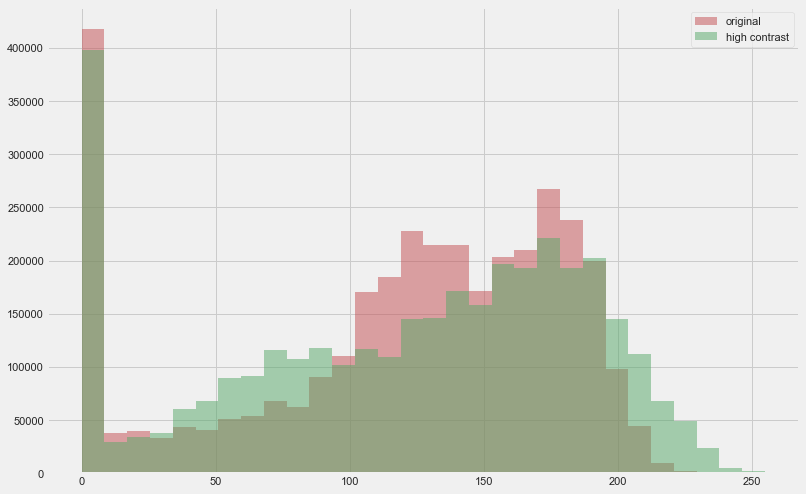

In [34]:
plt.figure(figsize=(12,8))
plt.hist(img[:,:,:].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5, label='original');
plt.hist(img_transformed[:,:,:].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5, label='high contrast');
plt.legend(loc='upper right')

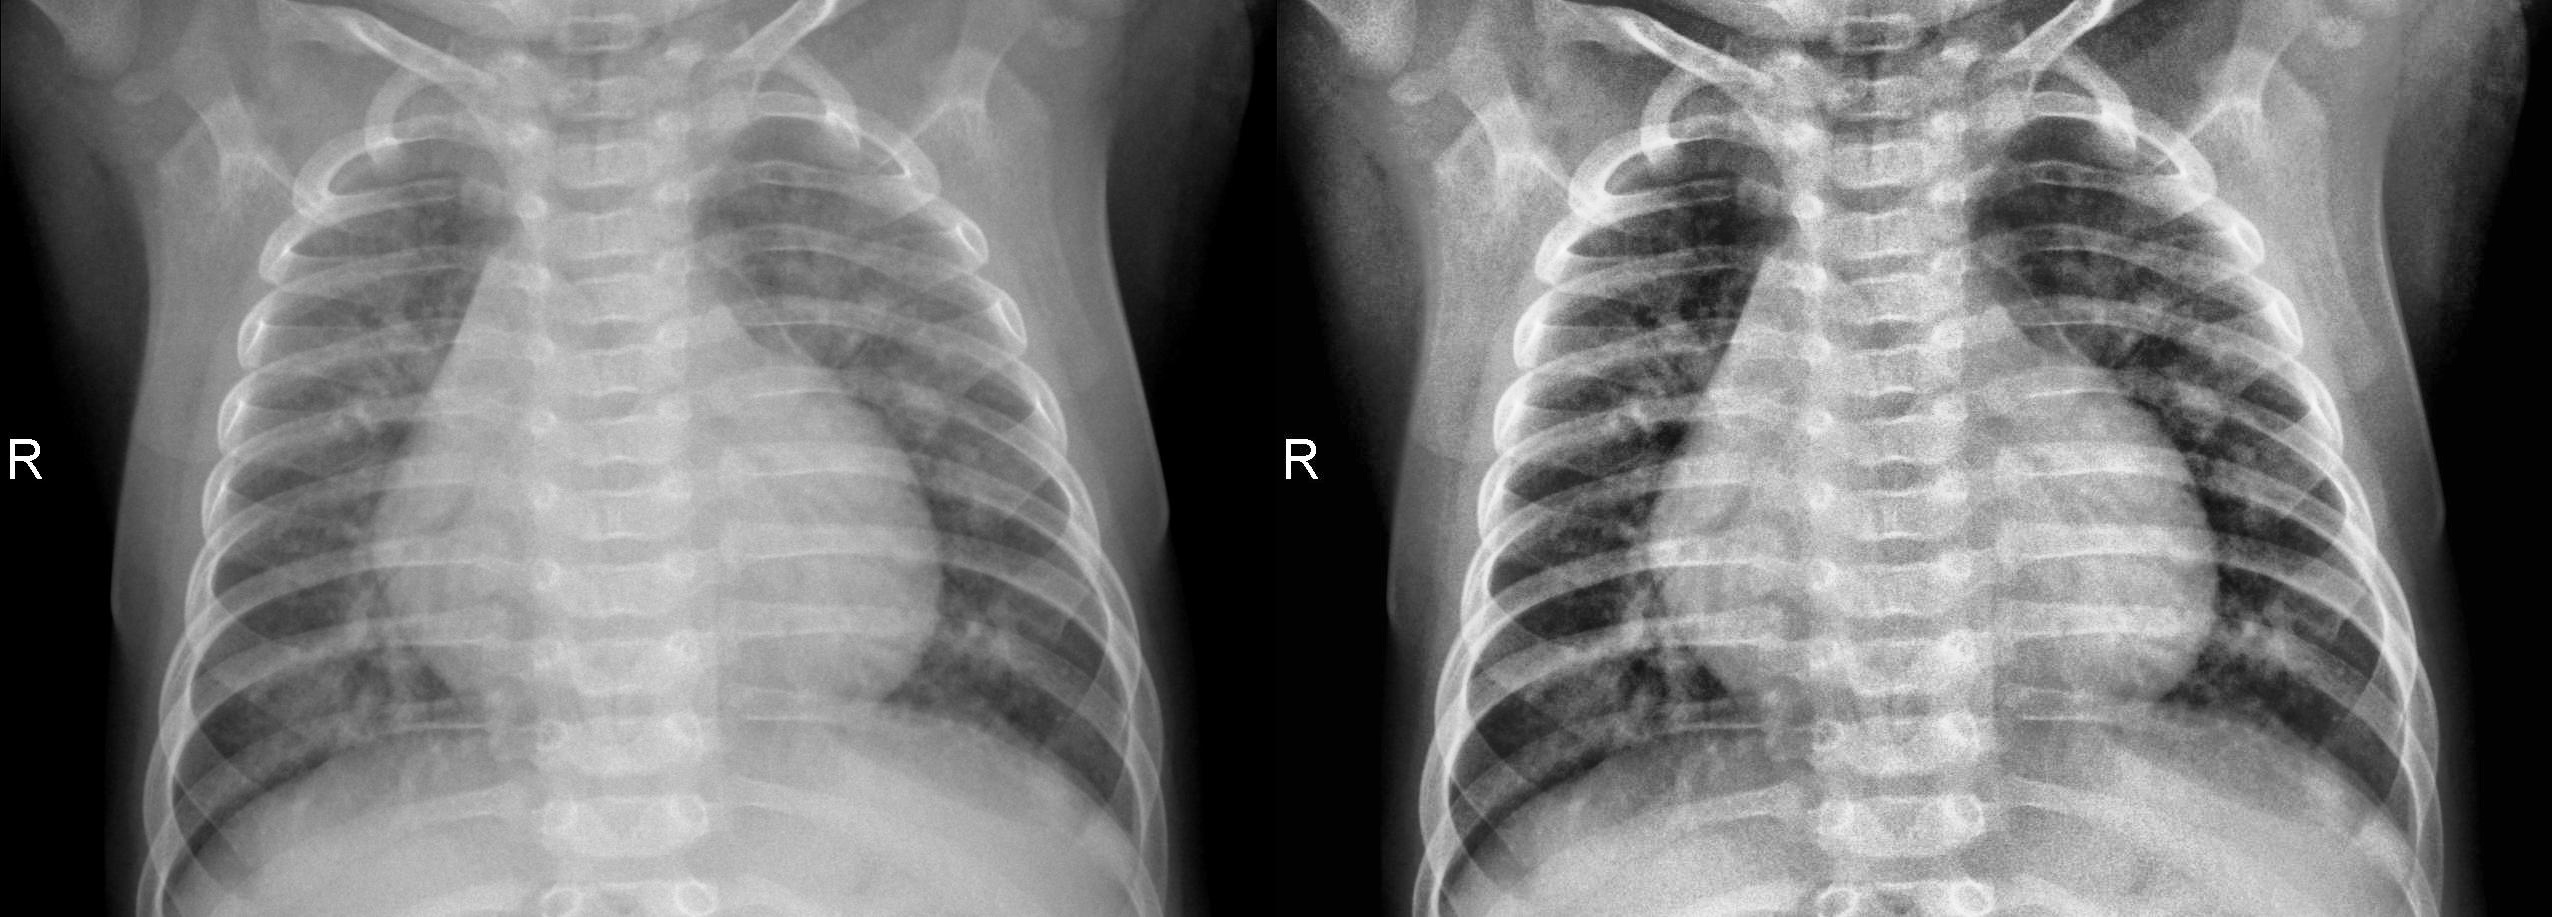

In [35]:
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
# create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
res = np.hstack((img,img_transformed))
cv2.imwrite('images/comparison.jpg',res)
load_img('images/comparison.jpg')

The image on the left is our original, while the image on the right is one with its contrast increased.

While an untrained human eye might still have issue detecting pneumonia in this x-ray, the hope is that it will make it easier for our model to pick up on patters.

In [36]:
# Create new directories to store the altered images
path = 'chest_xray_contrast'

# Check if the path already exists (we do this in case you already ran this code and generated the images locally)
isExist = os.path.exists(path)

if not isExist:
    os.makedirs(path)

directories = ['train', 'test']
sub_directories = ['NORMAL', 'PNEUMONIA']

if not isExist:
    for directory in directories:
        os.makedirs(path + '/' + directory)
        for sub_directory in sub_directories:
            os.makedirs(path + '/' + directory + '/' + sub_directory)

In [37]:
# Get file paths
if not isExist:
    train_pneumonia_img_files = []
    for file in os.listdir("chest_xray/train/PNEUMONIA/"):
        if file.endswith(".jpeg"):
            train_pneumonia_img_files.append("chest_xray/train/PNEUMONIA/" + os.path.relpath(file))

In [38]:
if not isExist:
    train_pneumonia_imgs_path_contrast = 'chest_xray_contrast/train/PNEUMONIA'

    for img_id, img_path in enumerate(train_pneumonia_img_files):
        img = cv2.imread(img_path, 0)
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{train_pneumonia_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

In [39]:
# Repeat the above for all other images & directories
if not isExist:
    # Get file paths for train NORMAL
    train_norm_img_files = []
    for file in os.listdir("chest_xray/train/NORMAL"):
        if file.endswith(".jpeg"):
            train_norm_img_files.append("chest_xray/train/NORMAL/" + os.path.relpath(file))

    # Get file paths for test PNEUMONIA
    test_pneumonia_img_files = []
    for file in os.listdir("chest_xray/test/PNEUMONIA"):
        if file.endswith(".jpeg"):
            test_pneumonia_img_files.append("chest_xray/test/PNEUMONIA/" + os.path.relpath(file))

    # Get file paths for test NORMAL
    test_norm_img_files = []
    for file in os.listdir("chest_xray/test/NORMAL"):
        if file.endswith(".jpeg"):
            test_norm_img_files.append("chest_xray/test/NORMAL/" + os.path.relpath(file))

In [40]:
if not isExist:
    # Transform train NORMAL images
    train_normal_imgs_path_contrast = 'chest_xray_contrast/train/NORMAL'

    for img_id, img_path in enumerate(train_norm_img_files):
        img = cv2.imread(img_path, 0)
        #create a CLAHE object (Arguments are optional).
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{train_normal_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

    # Transform test NORMAL images
    test_normal_imgs_path_contrast = 'chest_xray_contrast/test/NORMAL'

    for img_id, img_path in enumerate(test_norm_img_files):
        img = cv2.imread(img_path, 0)
        #create a CLAHE object (Arguments are optional).
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{test_normal_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

    # Transform test PNEUMONIA images
    test_pneumonia_imgs_path_contrast = 'chest_xray_contrast/test/PNEUMONIA'

    for img_id, img_path in enumerate(test_pneumonia_img_files):
        img = cv2.imread(img_path, 0)
        #create a CLAHE object (Arguments are optional).
        cl1 = clahe.apply(img)
        cv2.imwrite(f'{test_pneumonia_imgs_path_contrast}/clahe_21_{img_id}.jpg',cl1)

In [41]:
# Contrast Image Directory Path
train_contrast_path = 'chest_xray_contrast/train'
test_contrast_path = 'chest_xray_contrast/test'

train_contrast_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_contrast_path,
                                                     target_size=target_size,
                                                     batch_size = 4710,
                                                     subset='training',
                                                     seed=123)

val_contrast_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_contrast_path,
                                                     target_size=target_size,
                                                     batch_size = 522,
                                                     subset='validation',
                                                     seed=123)

test_contrast_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     test_contrast_path,
                                                     target_size=target_size,
                                                     batch_size=624,
                                                     seed=123)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [42]:
# Create the data sets
train_contrast_images, train_contrast_labels = next(train_contrast_generator)
test_contrast_images, test_contrast_labels = next(test_contrast_generator)
val_contrast_images, val_contrast_labels = next(val_contrast_generator)

In [43]:
train_contrast_y = np.reshape(train_contrast_labels[:,0], (4710,1))
test_contrast_y = np.reshape(test_contrast_labels[:,0], (624,1))
val_contrast_y = np.reshape(val_contrast_labels[:,0], (522,1))

### Second CNN Model using Higher Contrast Images

We're now ready to run another CNN model using the higher contrast images.

We'll also increase the model's complexity by adding more layers in hope of pushing our Accuracy and F1 scores higher.

I also introduce some dropout layers. With the increase in model complexity, I worry about overfitting and dropout layers should help with that.

In [44]:
# Path where we will save the first CNN model
second_cnn_checkpoint_filepath = 'models/second_cnn_model.h5'

##### Run the cell below to load the pre-trained model

In [45]:
second_cnn_model = load_model(second_cnn_checkpoint_filepath)

#### Uncomment & run the cell below if you want to compile & fit the model on your local machine

In [46]:
# # Constructing the model architecture
# second_cnn_model = models.Sequential()
# second_cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu',
#                         input_shape=(224, 224, 3)))
# second_cnn_model.add(layers.MaxPooling2D((2, 2)))

# second_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
# second_cnn_model.add(layers.MaxPooling2D((2, 2)))

# second_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# second_cnn_model.add(layers.MaxPooling2D((2, 2)))

# second_cnn_model.add(layers.Flatten())
# second_cnn_model.add(layers.Dense(64, activation='relu'))
# second_cnn_model.add(layers.Dropout(0.3))
# second_cnn_model.add(layers.Dense(16, activation='relu'))
# second_cnn_model.add(layers.Dense(1, activation='sigmoid'))

# # Compiling the model
# second_cnn_model.compile(loss='binary_crossentropy',
#               optimizer="sgd",
#               metrics=['acc'])


# # Define callback for saving best model
# second_cnn_checkpoint_callback = ModelCheckpoint(
#     filepath=second_cnn_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# second_cnn_logger = CSVLogger('logs/second_cnn_log.log')

# # Fit the model
# second_cnn_hist = second_cnn_model.fit(train_contrast_images,
#                     train_contrast_y,
#                     class_weight=class_weights,
#                     epochs=50,
#                     batch_size=32,
#                     callbacks=[second_cnn_checkpoint_callback, reduce_lr, second_cnn_logger],
#                     validation_data=(val_contrast_images, val_contrast_y))

In [47]:
second_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 108, 108, 32)      8224      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 26, 26, 64)      

17/17 [==============================] - 1s 56ms/step


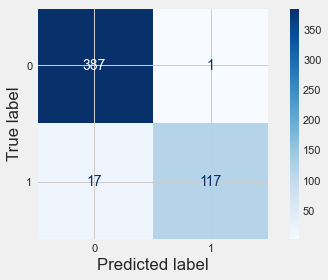

Accuracy: 0.965517
Precision: 0.991525
Recall: 0.873134
F1 score: 0.928571


In [48]:
# Evaluate model
evaluate_results(second_cnn_model, val_contrast_images, val_contrast_y)

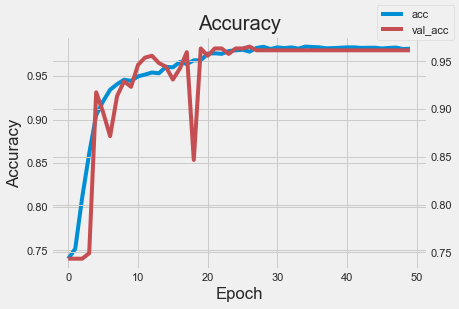

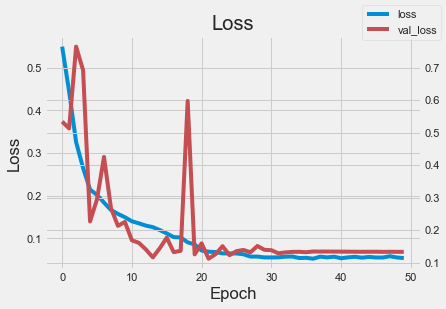

In [49]:
# Vizualize performance by epoch
visualize_training_results('logs/second_cnn_log.log')

This didn't do as well and the F1 metric dropped compared to our initial CNN. Recall got worse in particular.

Given the amount of research that recommends increasing contrast, we will continue iterating on this image set. However, we will use more complex pre-trained models which might be better suited.

## Transfer Learning
Transfer learning is a method whereby we bring in a model that was trained on another dataset and use it to try and solve our problem.

We will use the weights these pre-trained models learned on their original datasets (involving millions of images). These layers will be "frozen" meaning we will not train them on our data. We will then add some output layers to these models on which we will train our chest x-ray data.

### VGG19

VGG19 is a model that frequently comes up in research surrounding chest x-ray image classification. "VGG-19 is a convolutional neural network that is 19 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database" - [MathWorks](https://www.mathworks.com/help/deeplearning/ref/vgg19.html).

This model includes 16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer.

In [50]:
# First we initialize the pre-trained model which we already imported from Keras
# VGG19 expects a certain input so we define that as well

image_input = Input(shape=(224, 224, 3))
vgg_model = VGG19(input_tensor=image_input, include_top=False, weights='imagenet')

# Inspect the model architecture
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [51]:
# We add our own output layers on which we'll train the model using our chest x-ray data
outputs = vgg_model.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

In [52]:
# Initalize our custom VGG model with our custom outputs
custom_vgg_model = Model(inputs = vgg_model.input, outputs=outputs)

# We freeze the pre-trained VGG-19 layers
for layer in vgg_model.layers:
    layer.trainable = False

# Examine the model structure to make sure it looks like we expect it to
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [53]:
# Path where we will save the first CNN model
custom_vgg_checkpoint_filepath = 'models/custom_vgg.h5'

 #### Runt the cell below if you already have the pre-trained model on your machine and don't wish to re-train it

In [54]:
custom_vgg_model = load_model(custom_vgg_checkpoint_filepath)

#### Uncomment and run the cell below if you wish to fit the model locally. WARNING: This took 6 hours to fit

In [55]:
# # Define callback for saving best model 
# custom_vgg_checkpoint_callback = ModelCheckpoint(
#     filepath=custom_vgg_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# vgg_logger = CSVLogger('logs/custom_vgg19_log.log')

# # Compile the model
# custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['acc'])

# # Fit the model
# custom_vgg_hist = custom_vgg_model.fit(train_contrast_images,
#                     train_contrast_labels,
#                     class_weight=class_weights,
#                     batch_size=32,
#                     epochs=24,
#                     callbacks=[custom_vgg_checkpoint_callback, reduce_lr, vgg_logger],
#                     validation_data=(val_contrast_images, val_contrast_labels))

17/17 [==============================] - 30s 2s/step


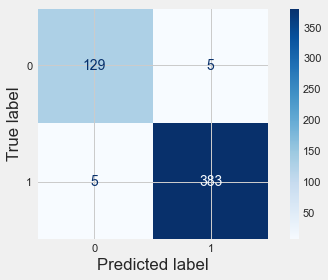

Accuracy: 0.980843
Precision: 0.987113
Recall: 0.987113
F1 score: 0.987113


In [56]:
# Evaluate the model on validation data
evaluate_results(custom_vgg_model, val_contrast_images, val_contrast_labels)

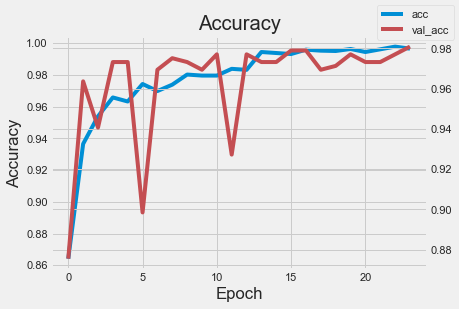

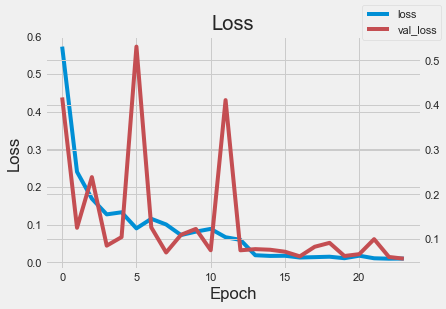

In [57]:
# Vizualize performance by epoch
visualize_training_results('logs/custom_vgg19_log.log')

With a 0.99 F1 score and amazing accuracy (0.98) this is the best model for our data so far. It's hard to imagine we will do better, but we can try one more pre-trained model that is frequently cited in research.

### ResNet
 We'll try one more pre-trained model which has performed well in chest x-ray imaging tasks -- ResNet.

In [58]:
resnet_model = ResNet50(input_tensor=image_input, include_top=False, weights='imagenet')

# Inspect the model architecture
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [59]:
res_outputs = resnet_model.output
res_outputs = Flatten(name="flatten")(res_outputs)
res_outputs = Dropout(0.3)(res_outputs)
res_outputs = Dense(2, activation="softmax")(res_outputs)

In [60]:
# Initalize our custom ResNet model with our custom outputs
custom_resnet_model = Model(inputs = resnet_model.input, outputs=res_outputs)

# We freeze the pre-trained ResNet layers
for layer in resnet_model.layers:
    layer.trainable = False

# Examine the model structure to make sure it looks like we expect it to
custom_resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [61]:
# Path where we will save the first CNN model
custom_resnet_checkpoint_filepath = 'models/custom_resnet_model.h5'

 #### Runt the cell below if you already have the pre-trained model on your machine and don't wish to re-train it

In [62]:
custom_resnet_model = load_model(custom_resnet_checkpoint_filepath)

In [63]:
# # Define callback for saving best model 
# custom_resnet_checkpoint_callback = ModelCheckpoint(
#     filepath=custom_resnet_checkpoint_filepath,
#     monitor='val_acc',
#     mode='max',
#     save_best_only=True)

# resnet_logger = CSVLogger('logs/custom_resnet.log')

# # Compile the model
# custom_resnet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['acc'])

# # Fit the model
# custom_resnet_hist = custom_resnet_model.fit(train_contrast_images,
#                     train_contrast_labels,
#                     class_weight=class_weights,
#                     batch_size=32,
#                     epochs=24,
#                     callbacks=[custom_resnet_checkpoint_callback, reduce_lr, resnet_logger],
#                     validation_data=(val_contrast_images, val_contrast_labels))

17/17 [==============================] - 14s 790ms/step


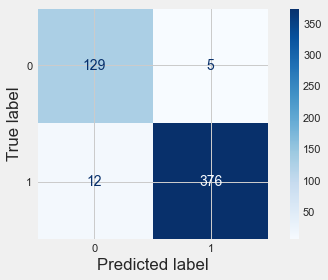

Accuracy: 0.967433
Precision: 0.986877
Recall: 0.969072
F1 score: 0.977893


In [64]:
# Evaluate the model on validation data
evaluate_results(custom_resnet_model, val_contrast_images, val_contrast_labels)

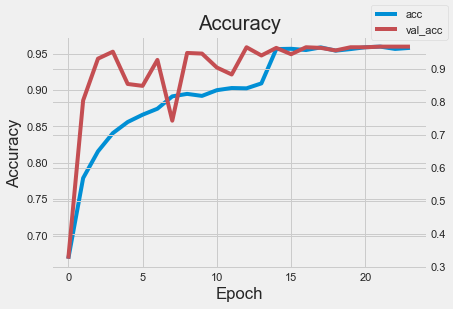

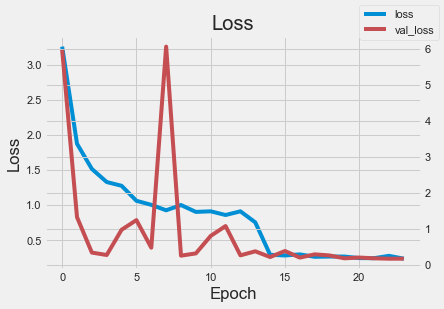

In [65]:
visualize_training_results('logs/custom_resnet.log')

While better than the models we constructed ourselves, it did not beat the performance of VGG19. So we will stop here and proceed with VGG19 as our final model.

## Evaluating The Final Model

Now that we have a model we this is well-suited for the business porblem, it's time to evaluate it on the our test data.

20/20 [==============================] - 39s 2s/step


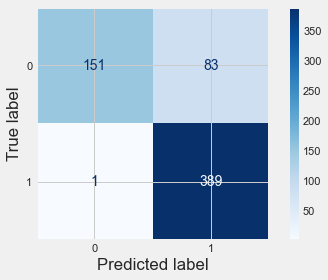

Accuracy: 0.865385
Precision: 0.824153
Recall: 0.997436
F1 score: 0.902552


In [66]:
evaluate_results(custom_vgg_model, test_contrast_images, test_contrast_labels)

Our final model did worse on the test data, but was still able to meet our F1 score threshold of 0.90. However, the model's precision is quite poor and it misclassified too many normal chest x-rays (83) as having pneumonia.

One potential reason for this is the class imbalance. Our training data did not have an equal number of normal and pneumonia cases. We had to use class_weights to account for this. As ACME collects more normal samples, we should look into re-training this model with a more balanced training set to try and improve performance and increase precision.

### Function for predicting single image

In [67]:
def detect_pneumonia(img_path):
    
    loaded_img = load_img(img_path, target_size=(224, 224))
    # Create a tensor of the images pixel values and rescale
    img_tensor = img_to_array(loaded_img)
    img_tensor = np.expand_dims(img_tensor, axis=0)/255
    prediction = custom_vgg_model.predict(img_tensor)
    highest_odds =  np.max(prediction)
    ind_get = np.where(prediction[0] == highest_odds)
    ind = ind_get[0]
    if ind == 0:
        diagnosis = 'No Pneumonia'
    else:
        diagnosis = 'Possible Pneumonia'
    
    print('Diagnosis: {}'.format(diagnosis))
    print('Model Confidence: {}'.format(highest_odds))
    display = cv2.imread(img_path)
    plt.figure(figsize=(15,5))
    plt.imshow(display)
    plt.axis('off')

1/1 [==============================] - 0s 85ms/step
Diagnosis: No Pneumonia
Model Confidence: 0.9580170512199402


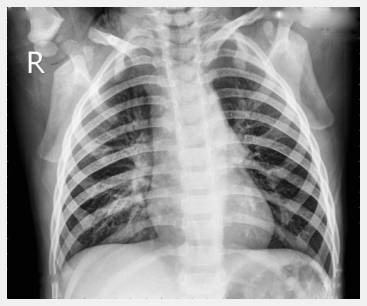

In [68]:
# Let's run this on a normal image
detect_pneumonia('chest_xray_contrast/train/NORMAL/clahe_21_90.jpg')

1/1 [==============================] - 0s 85ms/step
Diagnosis: Possible Pneumonia
Model Confidence: 1.0


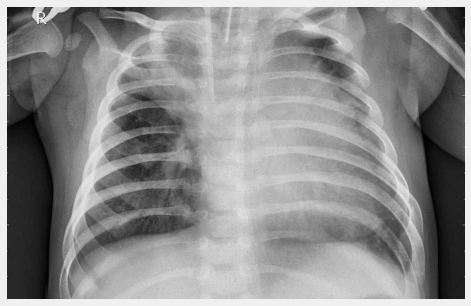

In [69]:
# Let's run this on an image containing pneumonia
detect_pneumonia('chest_xray_contrast/train/PNEUMONIA/clahe_21_42.jpg')

## Conclusions

* VGG19 was the best model for detecting pneumonia in chest x-rays
* The model achieved an F1 score 0.90 meeting our minimum threshold
* The precision of the model is quite poor (0.82) and it misclassified healthy chest x-rays as having pneumonia
* It's recommended we obtain more normal samples to train our model on to improve this